In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomTranslation, RandomWidth


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Only needed the first time to unzip the contents into input folder.
#!unzip /content/drive/MyDrive/datasets/'Copy of _output.zip' -d /content/drive/MyDrive/inputs/birdclef_sp_dataset1

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "/content/drive/MyDrive/inputs/birdclef_sp_dataset1/_output"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             labels='inferred',
                                             label_mode='categorical',
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             labels='inferred',
                                             label_mode='categorical',
                                             subset='validation',
                                             seed=42)

Found 6892 files belonging to 6 classes.
Using 5514 files for training.
Found 6892 files belonging to 6 classes.
Using 1378 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)


In [ ]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomTranslation(height_factor=0.2, width_factor=0.2))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation
augmenter = data_augmenter()

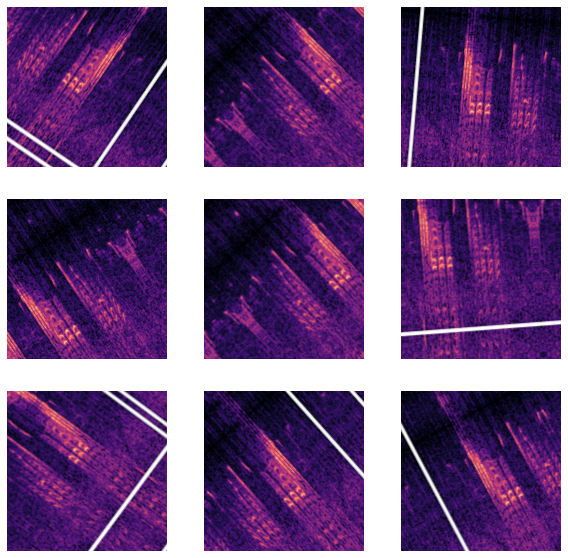

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


In [ ]:
def mel_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for multi classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new multi classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tf.keras.layers.Dense(6,activation='softmax')
    
    ### END CODE HERE
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
model2 = mel_model(IMG_SIZE, data_augmentation)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
173/173 [==============================] - 1633s 9s/step - loss: 1.2446 - categorical_accuracy: 0.6273 - val_loss: 1.5429 - val_categorical_accuracy: 0.6081
Epoch 2/5
173/173 [==============================] - 109s 607ms/step - loss: 1.0014 - categorical_accuracy: 0.7137 - val_loss: 1.1396 - val_categorical_accuracy: 0.7192
Epoch 3/5
173/173 [==============================] - 108s 606ms/step - loss: 1.0363 - categorical_accuracy: 0.7140 - val_loss: 1.1652 - val_categorical_accuracy: 0.7213
Epoch 4/5
173/173 [==============================] - 108s 606ms/step - loss: 1.0968 - categorical_accuracy: 0.7041 - val_loss: 1.3645 - val_categorical_accuracy: 0.7119
Epoch 5/5
173/173 [==============================] - 109s 607ms/step - loss: 1.0371 - categorical_accuracy: 0.7252 - val_loss: 1.4168 - val_categorical_accuracy: 0.7351


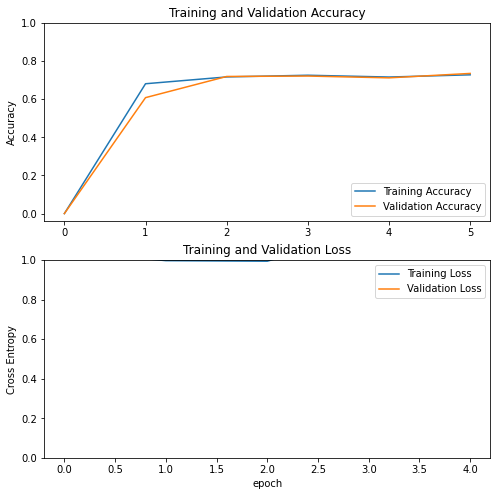

In [ ]:
acc = [0.] + history.history['categorical_accuracy']
val_acc = [0.] + history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Now with a bit of fine tuning, we only train a few of the last layers so that model trains for the specific task
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate *0.1)
# Use accuracy as evaluation metric
metrics=[tf.keras.metrics.CategoricalAccuracy()]

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Number of layers in the base model:  156
Epoch 5/10
173/173 [==============================] - 111s 601ms/step - loss: 0.8536 - categorical_accuracy: 0.7571 - val_loss: 1.0996 - val_categorical_accuracy: 0.7591
Epoch 6/10
173/173 [==============================] - 107s 597ms/step - loss: 0.8026 - categorical_accuracy: 0.7644 - val_loss: 1.0875 - val_categorical_accuracy: 0.7395
Epoch 7/10
173/173 [==============================] - 106s 592ms/step - loss: 0.7662 - categorical_accuracy: 0.7560 - val_loss: 0.9500 - val_categorical_accuracy: 0.7598
Epoch 8/10
173/173 [==============================] - 106s 591ms/step - loss: 0.7269 - categorical_accuracy: 0.7715 - val_loss: 0.8805 - val_categorical_accuracy: 0.7591
Epoch 9/10
173/173 [==============================] - 108s 602ms/step - loss: 0.7277 - categorical_accuracy: 0.7709 - val_loss: 0.8537 - val_categorical_accuracy: 0.7743
Epoch 10/10
173/173 [==============================] - 106s 594ms/step - loss: 0.6769 - categorical_accuracy: